In [38]:
import pandas as pd
import numpy as np

#from keras import callbacks,optimizers
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.datasets import co2
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error

# Atmospheric Co2 data

In [39]:
#Atmospheric CO2 from Continuous Air Samples at Mauna Loa Observatory, Hawaii, U.S.A.
#Period of Record: March 1958 - December 2001

data = co2.load().data
data = data.resample('M').mean().ffill()
data.head(20)

,co2
1958-03-31,316.100000
1958-04-30,317.200000
1958-05-31,317.433333
1958-06-30,317.433333
1958-07-31,315.625000
1958-08-31,314.950000
1958-09-30,313.500000
1958-10-31,313.500000
1958-11-30,313.425000
1958-12-31,314.700000


# STL decomposition

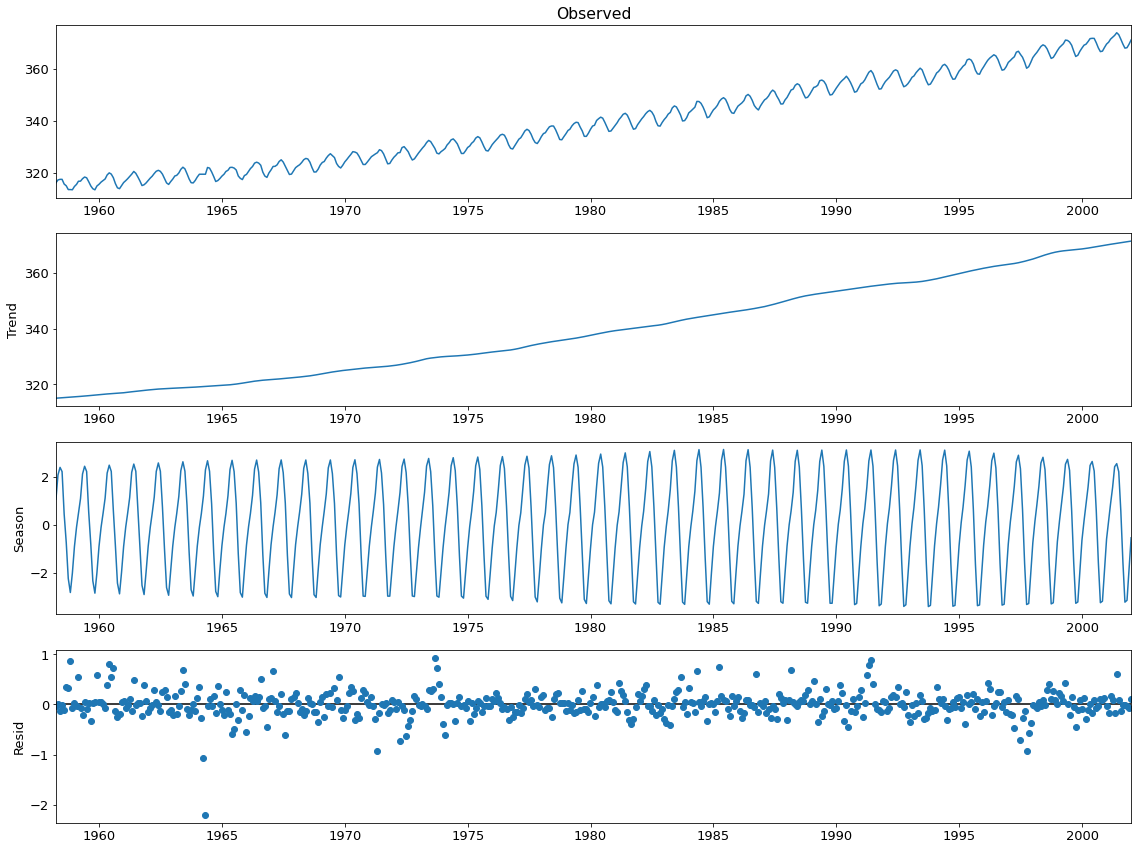

In [40]:
stl = STL(data,seasonal=13, robust=True).fit()
plt.rc("figure", figsize=(16, 12))
plt.rc("font", size=13)
stl.plot()
plt.show()
plt.close()
res = stl.resid
trend = stl.trend
seas= stl.seasonal

In [41]:
# check for stationarity

def test_adfuller(data):
    result = adfuller(data)
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))
    return
test_adfuller(res)


ADF Statistic: -16.29677649360292
p-value: 3.2965671471007973e-29
Critical Values:
	1%: -3.4428672600488066
	5%: -2.8670609714890403
	10%: -2.5697104770975057


# Forecasting using STL decomposed with simple exponential smoothing

In [42]:
fit1 = SimpleExpSmoothing(res[:-12], initialization_method="estimated").fit()
fcast1 = fit1.forecast(12) + trend[-12:] + seas[-12:] # put back the trend + seasonal


# Method2: AutoArima

In [43]:
train = data[:-12]
test = data[-12:]

myarima= auto_arima(train, max_p=5, max_d=3, max_q =5,max_P=5, max_D=3, max_Q=5, max_order=5, m=12, seasonal=True, stationary=False, information_criterion='bic', alpha=0.05)#, test='kpss', seasonal_test='ocsb
#',stepwise=True, n_jobs=1, start_params=None, trend=None, method='lbfgs', maxiter=50, offset_test_args=None, seasonal_test_args=None, suppress_warnings=True, error_action='trace', trace=False, random=False, random_state=None, n_fits=25, return_valid_fits=False, out_of_sample_size=0, scoring='mse')
myarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  514
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -173.650
Date:                            Sun, 04 Dec 2022   AIC                            357.299
Time:                                    18:30:30   BIC                            378.500
Sample:                                03-31-1958   HQIC                           365.609
                                     - 12-31-2000                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3564      0.101      3.514      0.000       0.158       0.555
ma.L1         -0.6642      0.085     -7.857      0.000      -0.830      -0.499
ar.S.L12       0.9994      0.001   1903.014      0.000       0.998       1.000
ma.S.L12      -0.8538      0.030    -28.814      0.000      -0.912      -0.796
sigma2         0.1042      0.006     18.858      0.000       0.093       0.115
===================================================================================
Ljung-Box (L1) (Q):                   0.21   Jarque-Bera (JB):                22.30
Prob(Q):                              0.65   Prob(JB):                         0.00
Heteroskedasticity (H):               0.61   Skew:                            -0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [46]:
#forcast
fcast2 = myarima.predict(n_periods=12)
print (fcast2)


2001-01-31    370.515833
2001-02-28    371.247354
2001-03-31    372.188045
2001-04-30    373.453143
2001-05-31    373.842596
2001-06-30    373.299879
2001-07-31    371.826059
2001-08-31    369.776873
2001-09-30    368.042234
2001-10-31    368.278120
2001-11-30    369.640215
2001-12-31    371.020561
Freq: M, dtype: float64


Text(0, 0.5, 'Co2 measure(AU)')

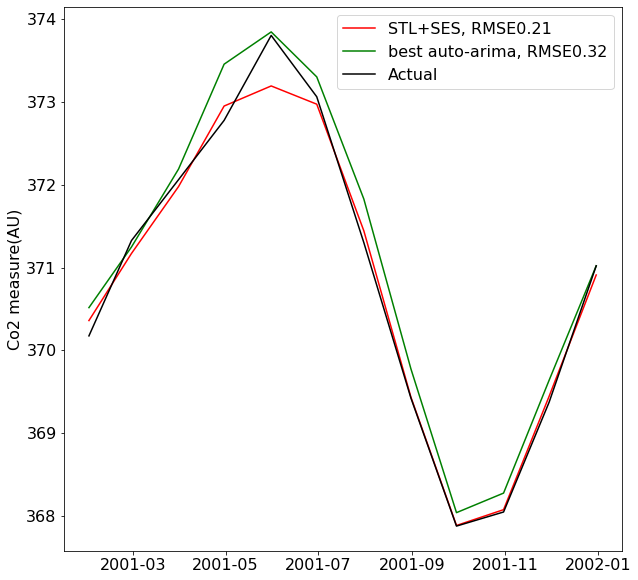

In [48]:
rmse1 = np.sqrt(mean_squared_error(test,fcast1)) #method1
rmse2 = np.sqrt(mean_squared_error(test,fcast2)) # method 2

plt.rc("figure", figsize=(10, 10))
plt.rc("font", size=16)
plt.plot(fcast1,'r-',label=f'STL+SES, RMSE{np.round(rmse1,2)}')
plt.plot(fcast2,'g-',label=f'best auto-arima, RMSE{np.round(rmse2,2)}')
plt.plot(test,'k-', label='Actual')
plt.legend()
plt.ylabel('Co2 measure(AU)')